In [ ]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import shapes
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic
from shapely.geometry import shape
from rasterstats import zonal_stats

%matplotlib inline

%load_ext autoreload
%autoreload 2

from gridflow import model
from gridflow.visuals import country_viz
from gridflow import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
plt.style.use('fivethirtyeight')

### Demo notebook
This notebook demonstrates the capabilities of the gridflow package.

In [ ]:
from gridflow import model
from gridflow.visuals import country_viz
from gridflow.epm_input_generator import generate_epm_inputs
countries = ["LUX"]

In [ ]:
lux = model.region(countries, 'data/global_datasets')
lux.create_zones(n=5)

In [ ]:
lux.zones

,geometry,country
0,"POLYGON ((6.01667 50.18333, 6.01667 50.175, 5....",LUX
1,"POLYGON ((6.00833 49.90833, 6.00833 49.9, 5.98...",LUX
2,"POLYGON ((6.20833 49.89167, 6.20833 49.88333, ...",LUX
3,"MULTIPOLYGON (((6.36667 49.85, 6.36667 49.8416...",LUX
4,"MULTIPOLYGON (((5.99167 49.69167, 5.99167 49.6...",LUX


In [ ]:
lux.zone_stats

,population
0,100577.015625
1,50612.015625
2,200653.359375
3,188002.625000
4,516025.562500


In [ ]:
lux.create_network()

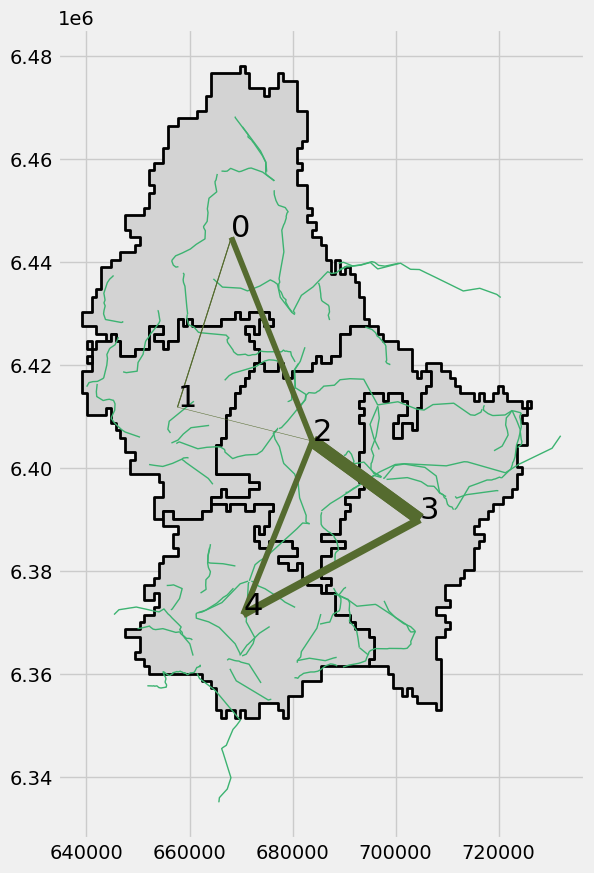

In [ ]:
country_viz(lux)

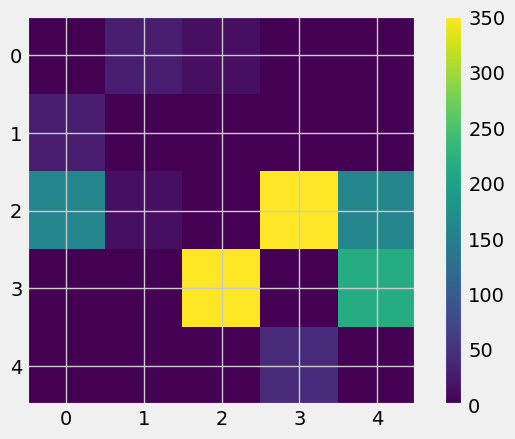

In [ ]:
plt.imshow(lux.grid.flow)
plt.colorbar()